## Regular Log Reg

In [10]:
import pandas as pd
from train_eval_functions import *
import importlib
import joblib

In [158]:
#defining all load data scenarios
from sklearn.model_selection import train_test_split

def stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200):
    train_class_distribution = train_df['mortality_ten_years'].value_counts(normalize=True)
    rounded_distribution = (train_class_distribution * 100).round().astype(int)
    #print(rounded_distribution)
    #print(id_test_df['mortality_ten_years'].value_counts(normalize=True))
    #print(ood_test_df['mortality_ten_years'].value_counts(normalize=True))

    id_test_df = stratified_sample(id_test_df, target_col='mortality_ten_years', n_samples=n_samples, class_distribution=rounded_distribution)
    ood_test_df = stratified_sample(ood_test_df, target_col='mortality_ten_years', n_samples=n_samples, class_distribution=rounded_distribution)

    return train_df, id_test_df, ood_test_df

def fill_na_val(train_df, id_test_df, ood_test_df):
    train_df = train_df.fillna(-999)
    id_test_df = id_test_df.fillna(-999)
    ood_test_df = ood_test_df.fillna(-999)

    X_train, y_train = split_dataset_into_x_y(train_df, 'mortality_ten_years')
    X_id_test, y_id_test = split_dataset_into_x_y(id_test_df, 'mortality_ten_years')
    X_ood_test, y_ood_test = split_dataset_into_x_y(ood_test_df, 'mortality_ten_years')

    return X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test

def impute(train_df, id_test_df, ood_test_df):
    imp_norm_pipe = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="mean",missing_values=pd.NA)),
            ("normalizer", StandardScaler())])
    
    X_train, y_train = split_dataset_into_x_y(train_df, 'mortality_ten_years')
    X_id_test, y_id_test = split_dataset_into_x_y(id_test_df, 'mortality_ten_years')
    X_ood_test, y_ood_test = split_dataset_into_x_y(ood_test_df, 'mortality_ten_years')

    all_na_cols = X_train.columns[X_train.isna().all()]
    X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)  
    X_train = pd.DataFrame(imp_norm_pipe.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

    X_id_test = X_id_test.drop(columns=all_na_cols).fillna(np.nan)  
    X_id_test = pd.DataFrame(imp_norm_pipe.transform(X_id_test), columns=X_id_test.columns, index=X_id_test.index)

    X_ood_test = X_ood_test.drop(columns=all_na_cols).fillna(np.nan)  
    X_ood_test = pd.DataFrame(imp_norm_pipe.transform(X_ood_test), columns=X_ood_test.columns, index=X_ood_test.index)

    return X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test

def load_data_scenario_1(imputed=False):
    '''
    Train: 2006-2010
    ID Test: 2012
    OOD Test: 2014-2016
    '''

    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
    train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
    id_test_df = data_dict['2012']
    ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)

    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_2(imputed=False):
    '''
    Train: 2006-2008
    ID Test: 2010-2012
    OOD Test: 2014-2016
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
    train_df = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
    id_test_df = pd.concat([data_dict['2010'], data_dict['2012']], ignore_index=True)
    ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)
    
    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_3(imputed=False):
    '''
    Train: 2006-2010 (80%)
    ID Test: 2006-2010 (20%)
    OOD Test: 2016
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')

    dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
    X_dataset = dataset.drop(columns=["mortality_ten_years"])
    y_dataset = dataset["mortality_ten_years"]
    X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

    train_df = pd.concat([X_train, y_train], axis=1)
    id_test_df = pd.concat([X_id_test, y_id_test], axis=1)
    ood_test_df = data_dict['2016']

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_4(imputed=False):
    '''
    Train: 2006-2014 (80%) all regions except 11 1 2
    ID Test: 2006-2014 (20%) all regions except 11 1 2
    OOD Test: 2016. 11, 1, 2
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
    dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014']], ignore_index=True)

    dataset.drop(dataset[dataset['state_live_current'].isin([97, 98, 99, 11, 1, 2])].index, inplace=True)

    X_dataset = dataset.drop(columns=["mortality_ten_years"])
    y_dataset = dataset["mortality_ten_years"]

    X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

    train_df = pd.concat([X_train, y_train], axis=1)
    id_test_df = pd.concat([X_id_test, y_id_test], axis=1)
    ood_test_df = data_dict['2016']
    ood_test_df.drop(ood_test_df[~ood_test_df['state_live_current'].isin([11, 1, 2])].index, inplace=True)

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_5(imputed=False):
    '''
    Train: 2006-2016 (80%) regions 3, 4, 5, 6
    ID Test: 2006-2016 (20%) regions 3, 4, 5, 6
    OOD Test: 2006-2016 region 1
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')

    dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014'], data_dict['2016']], ignore_index=True)
    dataset.drop(dataset[dataset['race'].isin([-999, 8, 9, 2, 7])].index, inplace=True)

    X_dataset = dataset.drop(columns=["mortality_ten_years"])
    y_dataset = dataset["mortality_ten_years"]

    X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

    train_df = pd.concat([X_train, y_train], axis=1)
    id_test_df = pd.concat([X_id_test, y_id_test], axis=1)
    ood_test_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014'], data_dict['2016']], ignore_index=True)
    ood_test_df.drop(ood_test_df[~ood_test_df['state_live_current'].isin([1])].index, inplace=True)

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_6(imputed=False):
    '''
    Train: 2006-2010 (80%)
    ID Test: 2010-2012 (20%)
    OOD Test: 2014-2016
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')

    dataset = data_dict['2010']
    X_dataset = dataset.drop(columns=["mortality_ten_years"])
    y_dataset = dataset["mortality_ten_years"]

    X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

    dataset = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
    X_train = pd.concat([dataset.drop(columns=["mortality_ten_years"]), X_train])
    y_train = pd.concat([dataset["mortality_ten_years"], y_train])

    id_test_df = data_dict['2012']
    X_id_test = pd.concat([id_test_df, X_id_test])
    y_id_test = pd.concat([id_test_df["mortality_ten_years"], y_id_test])

    train_df = pd.concat([X_train, y_train], axis=1)
    id_test_df = pd.concat([X_id_test.drop(columns=["mortality_ten_years"]), y_id_test], axis=1)
    ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

In [144]:
importlib.reload(train_eval_functions)
from train_eval_functions import *

load_functions = [
    load_data_scenario_1,
    load_data_scenario_2,
    load_data_scenario_3,
    load_data_scenario_4,
    load_data_scenario_5,
    load_data_scenario_6
]

save_paths = [
    'logistic_reg_1',
    'logistic_reg_2',
    'logistic_reg_3',
    'logistic_reg_4',
    'logistic_reg_5',
    'logistic_reg_6'
]

all_was_dist = []
all_sp = []
all_eo = []
all_max_gap = []

for idx, load_func in enumerate(load_functions):
    X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_func(imputed=False)

    logistic_reg = joblib.load("./log_reg/"+save_paths[idx]+"_weights.pkl")

    #logistic_reg = LogisticRegression(max_iter=1, warm_start=True, random_state=42)
    #logistic_reg = train_over_iterations(logistic_reg, X_train, y_train, 250, save_as="./log_reg/"+save_paths[idx]+"_training.png")
    #logistic_reg = train_to_convergence(logistic_reg, X_train_filled, y_train)
    evaluate(logistic_reg, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as="./log_reg/"+save_paths[idx]+"_eval.txt")

    sp, eo, max_gap = get_fairness_metrics(logistic_reg, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True)
    all_sp.append(sp)
    all_eo.append(eo)
    all_max_gap.append(max_gap)

    wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
    all_was_dist.append(wd)

    #joblib.dump(logistic_reg, "./log_reg/"+save_paths[idx]+"_weights.pkl")


/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/520233861.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/520233861.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df = train_df.fillna(-999)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/520233861.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .

## Statistical Parity 

Assesses whether individuals from different groups receive positive predictions at the same rate. Calculated by comparing positive prediction rates across the sensitive groups. A fair model should have a smaller statistical parity difference (value of 0). 

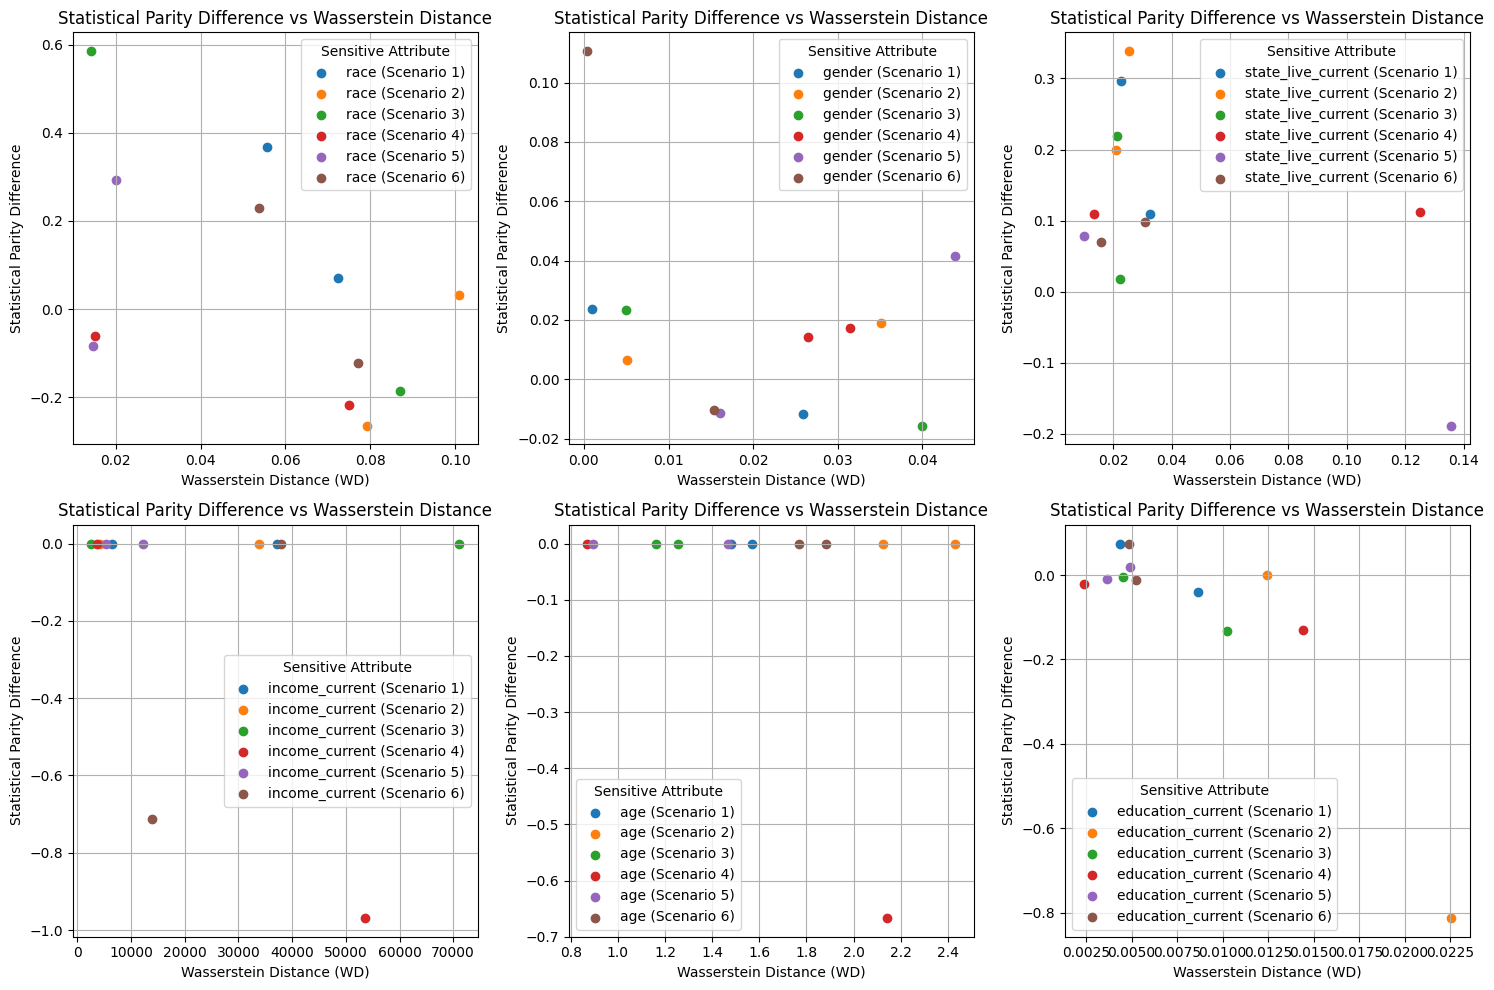

In [152]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_sp)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_sp[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Statistical Parity Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Statistical Parity Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

## Equalized Odds Difference

Checks whether error rates are equal across groups (specifically FPR and FNR) and measures the largest difference in FPR and FNR between groups. A fair model should have a smaller equalized odd difference value (closer to 0)

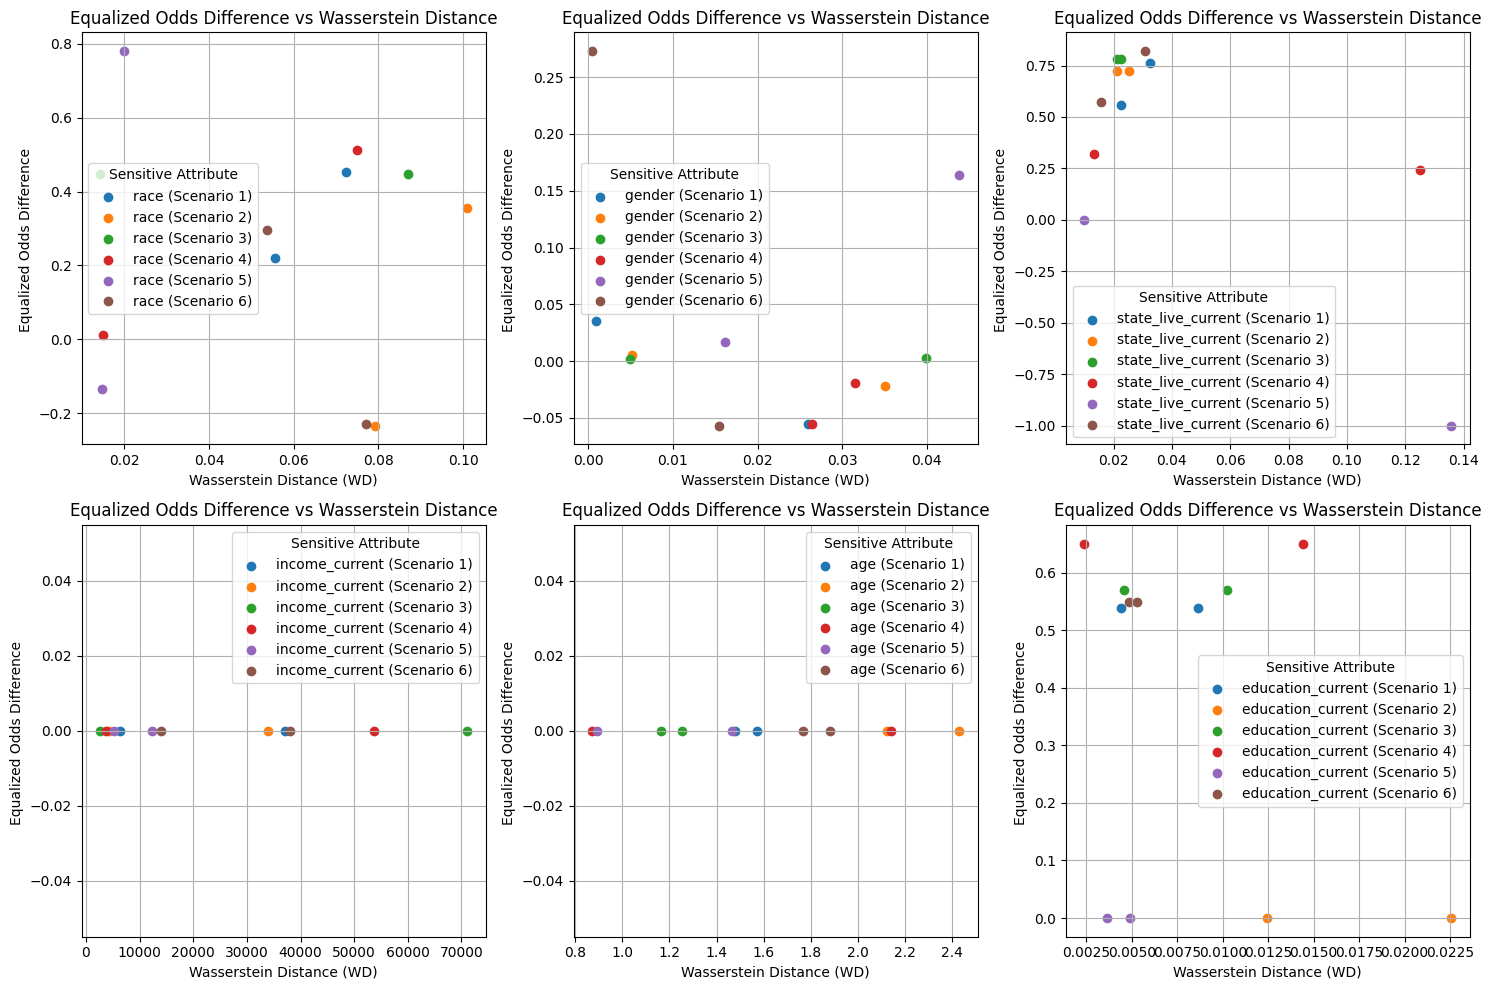

In [150]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_eo)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_eo[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Equalized Odds Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Equalized Odds Difference ")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

## Max Calibration Gap

Evaluates how well the predicted probabilities align with actual outcomes, broken down by groups. Calculated by measuring the largest difference between predicted probabilities and observed outcomes for any group. A smaller calibration gap means a fairer model (closer to 0)

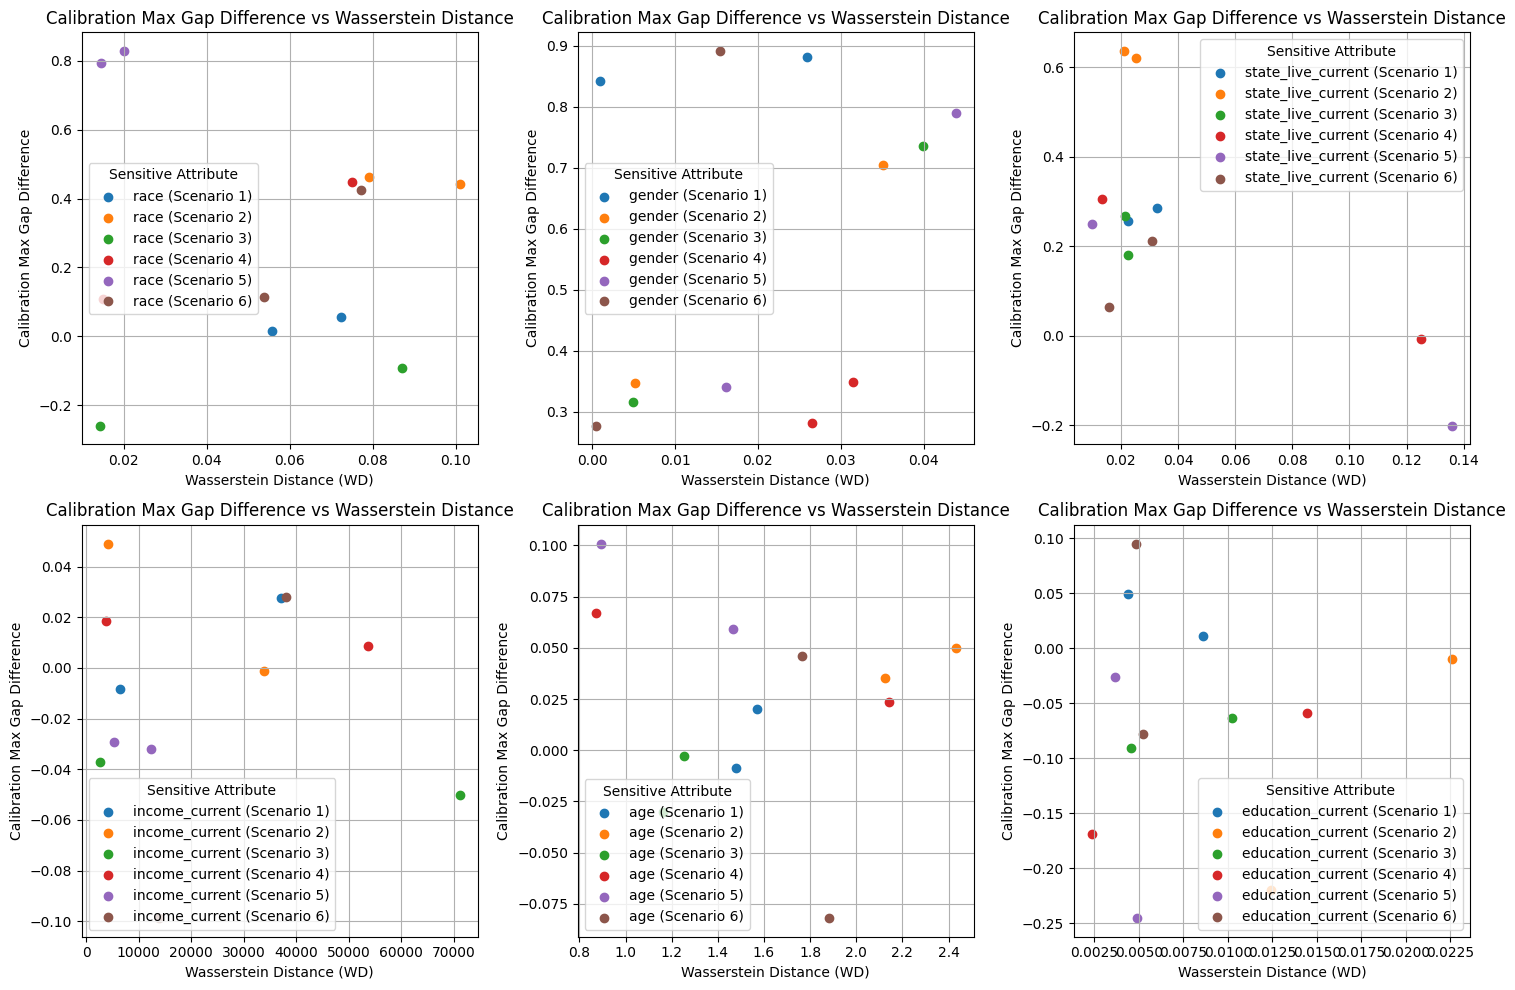

In [153]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_max_gap)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_max_gap[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Calibration Max Gap Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Calibration Max Gap Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [149]:
#save

import pickle

with open('./log_reg/log_reg_was_dist.pkl', 'wb') as file:
    pickle.dump(all_was_dist, file)

with open('./log_reg/log_reg_sp.pkl', 'wb') as file:
    pickle.dump(all_sp, file)

with open('./log_reg/log_reg_eo.pkl', 'wb') as file:
    pickle.dump(all_eo, file)

with open('./log_reg/log_reg_max_gap.pkl', 'wb') as file:
    pickle.dump(all_max_gap, file)

# Imputed Log Reg

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:40: FutureWarning: Downcasting obje

  0%|          | 0/250 [00:00<?, ?it/s]

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:40: FutureWarning: Downcasting object dtype arrays on 

  0%|          | 0/250 [00:00<?, ?it/s]

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:40: FutureWarning: Downcasting objec

  0%|          | 0/250 [00:00<?, ?it/s]

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.

  0%|          | 0/250 [00:00<?, ?it/s]

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:145: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014'], data_dict['2016']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ood_test_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], dat

  0%|          | 0/250 [00:00<?, ?it/s]

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:179: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_train = pd.concat([dataset.drop(columns=["mortality_ten_years"]), X_train])
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: 

  0%|          | 0/250 [00:00<?, ?it/s]

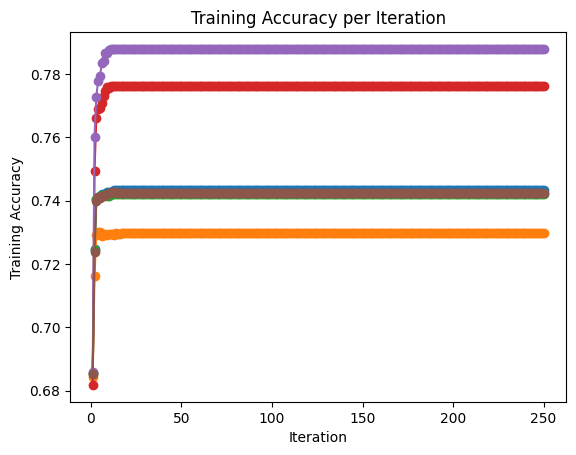

In [160]:
importlib.reload(train_eval_functions)
from train_eval_functions import *

load_functions = [
    load_data_scenario_1,
    load_data_scenario_2,
    load_data_scenario_3,
    load_data_scenario_4,
    load_data_scenario_5,
    load_data_scenario_6
]

save_paths = [
    'logistic_reg_imputed_1',
    'logistic_reg_imputed_2',
    'logistic_reg_imputed_3',
    'logistic_reg_imputed_4',
    'logistic_reg_imputed_5',
    'logistic_reg_imputed_6'
]

all_was_dist = []
all_sp = []
all_eo = []
all_max_gap = []

for idx, load_func in enumerate(load_functions):
    X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_func(imputed=True)

    #logistic_reg = joblib.load("./log_reg_imputed/"+save_paths[idx]+"_weights.pkl")

    logistic_reg = LogisticRegression(max_iter=1, warm_start=True, random_state=42)
    logistic_reg = train_over_iterations(logistic_reg, X_train, y_train, 250, save_as="./log_reg_imputed/"+save_paths[idx]+"_training.png")
    #logistic_reg = train_to_convergence(logistic_reg, X_train_filled, y_train)
    evaluate(logistic_reg, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as="./log_reg_imputed/"+save_paths[idx]+"_eval.txt")

    sp, eo, max_gap = get_fairness_metrics(logistic_reg, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True)
    all_sp.append(sp)
    all_eo.append(eo)
    all_max_gap.append(max_gap)

    wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
    all_was_dist.append(wd)

    joblib.dump(logistic_reg, "./log_reg_imputed/"+save_paths[idx]+"_weights.pkl")


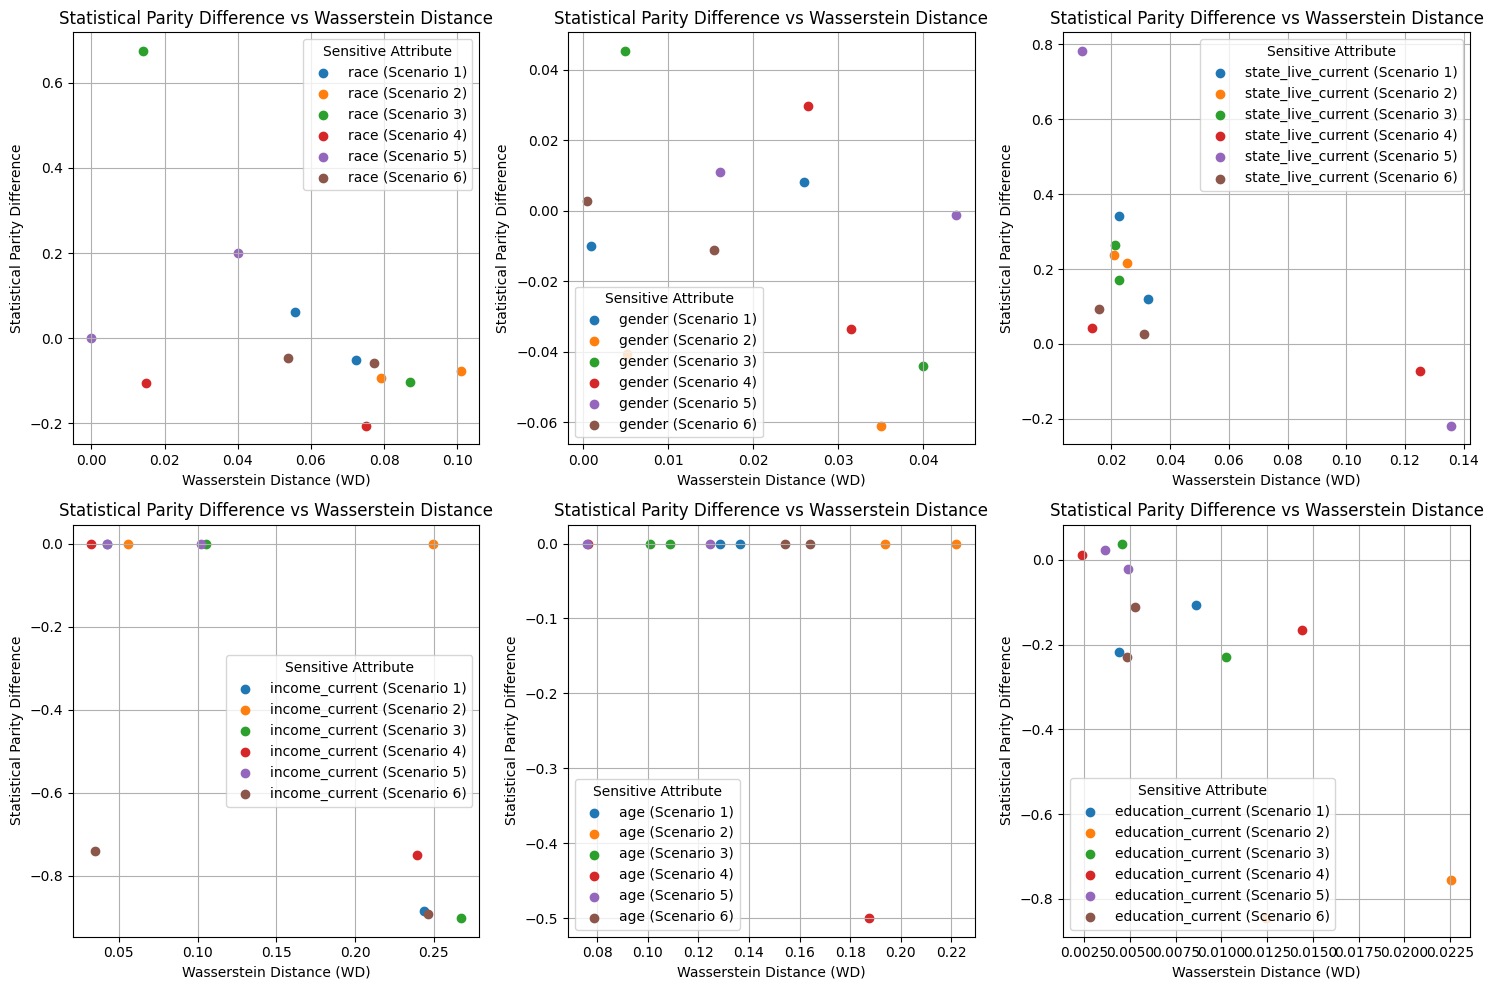

In [161]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_sp)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_sp[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Statistical Parity Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Statistical Parity Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

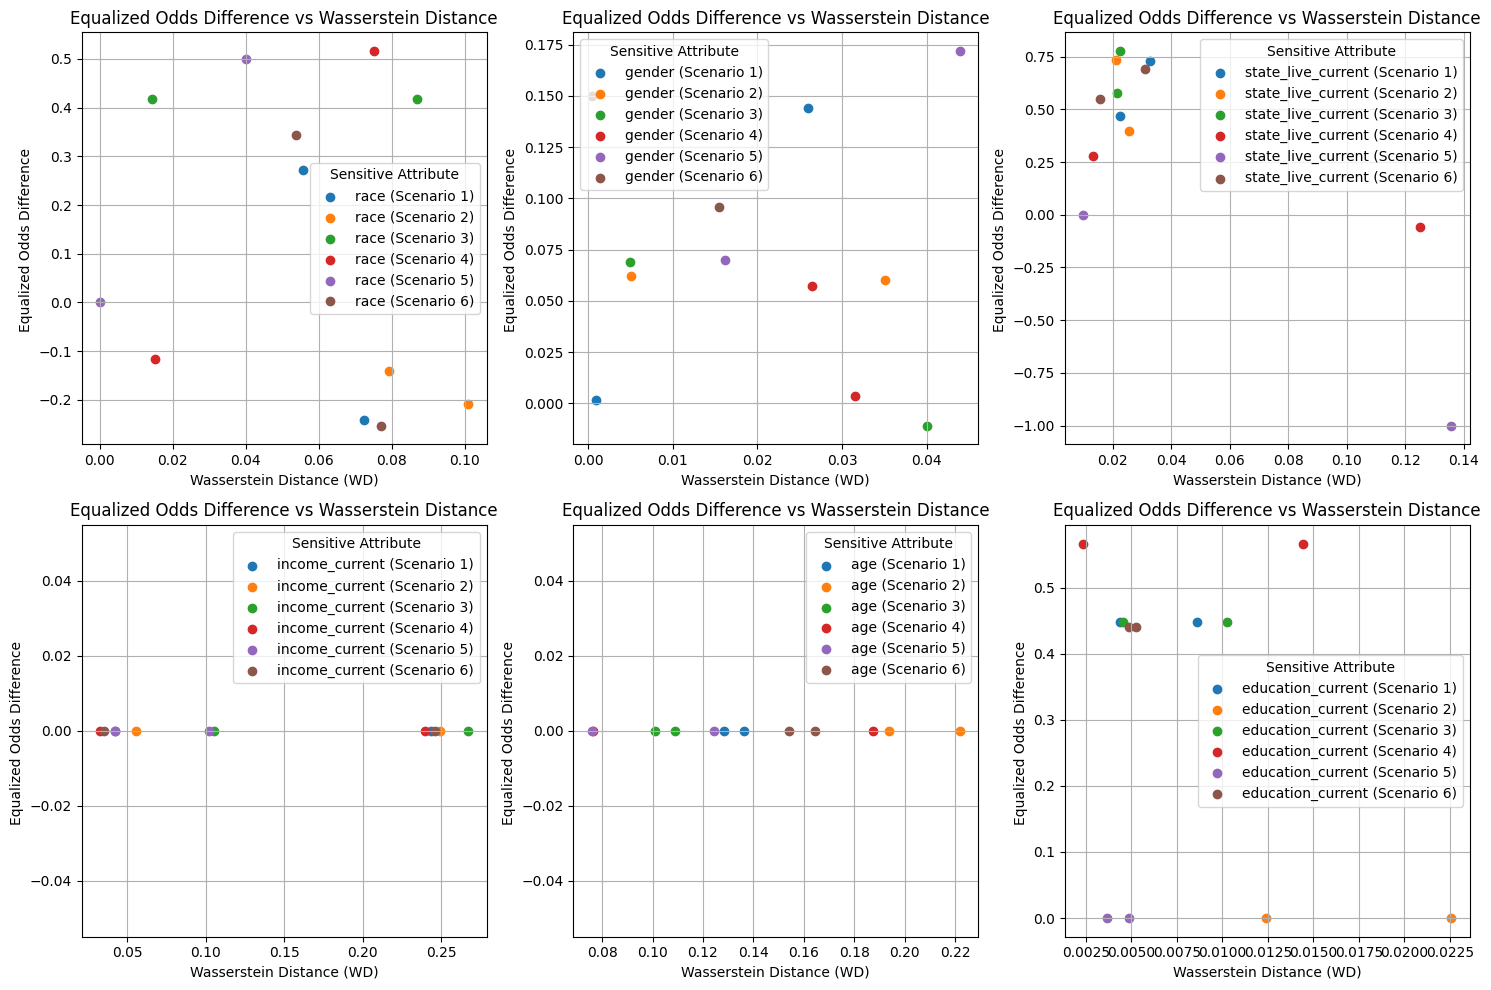

In [162]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_eo)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_eo[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Equalized Odds Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Equalized Odds Difference ")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

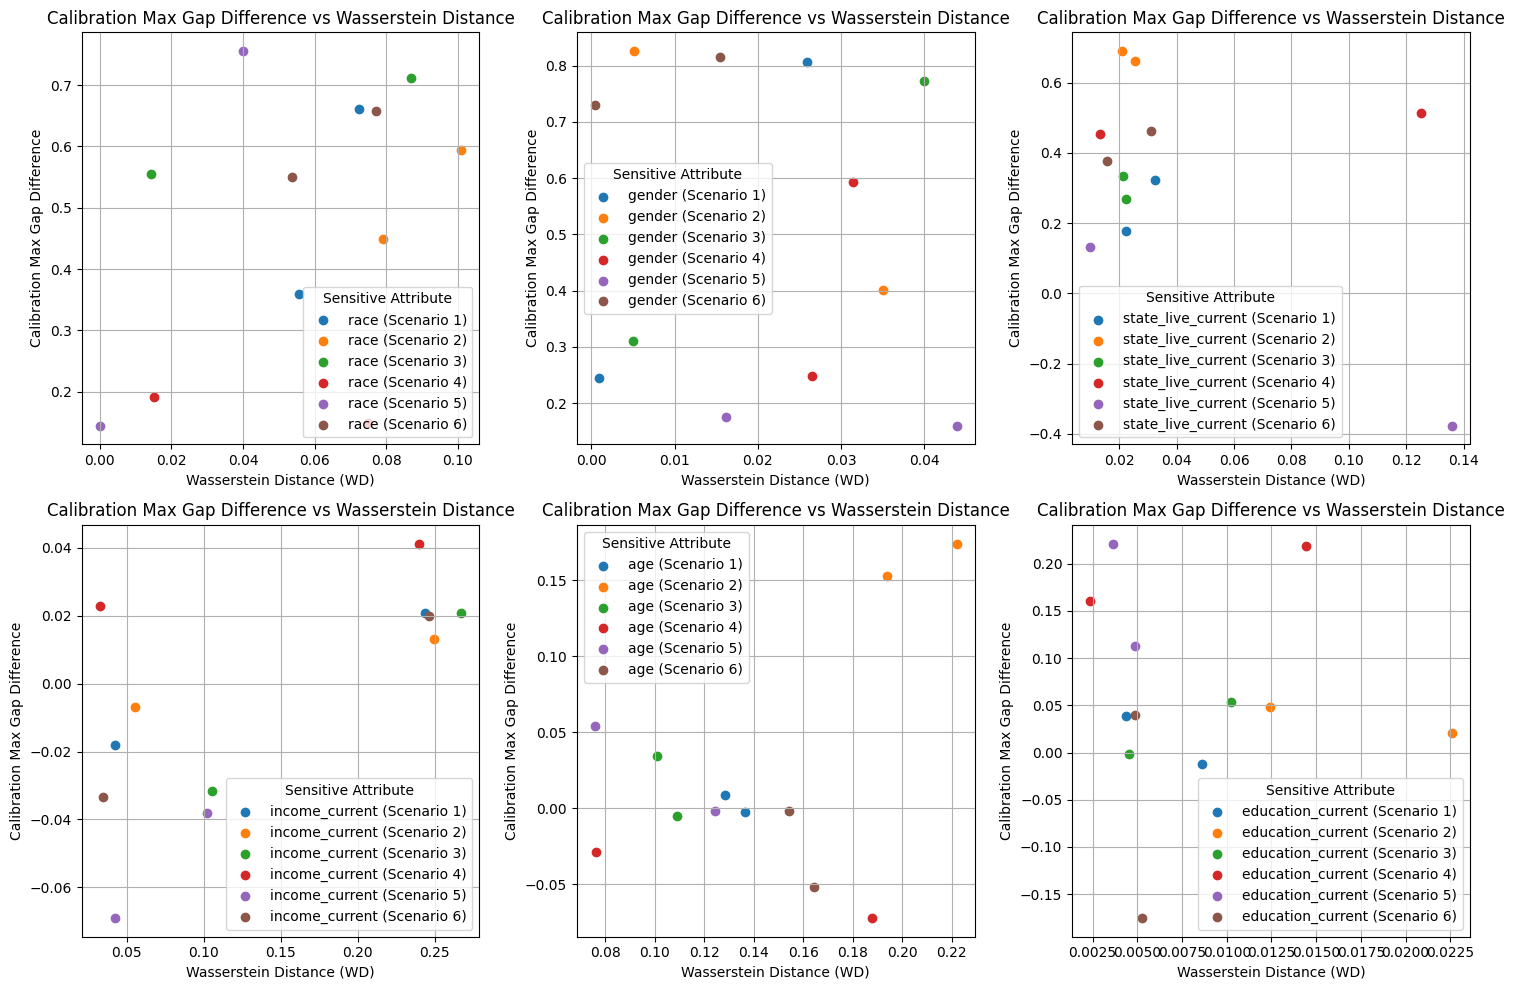

In [163]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_max_gap)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_max_gap[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Calibration Max Gap Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Calibration Max Gap Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [164]:
#save

import pickle

with open('./log_reg_imputed/log_reg_imputed_was_dist.pkl', 'wb') as file:
    pickle.dump(all_was_dist, file)

with open('./log_reg_imputed/log_reg_imputed_sp.pkl', 'wb') as file:
    pickle.dump(all_sp, file)

with open('./log_reg_imputed/log_reg_imputed_eo.pkl', 'wb') as file:
    pickle.dump(all_eo, file)

with open('./log_reg_imputed/log_reg_imputed_max_gap.pkl', 'wb') as file:
    pickle.dump(all_max_gap, file)

# Imputed MLP

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:40: FutureWarning: Downcasting obje

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:40: FutureWarning: Downcasting object dtype arrays on 

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:40: FutureWarning: Downcasting objec

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:116: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:145: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014'], data_dict['2016']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ood_test_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], dat

  0%|          | 0/50 [00:00<?, ?it/s]

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:179: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:180: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_train = pd.concat([dataset.drop(columns=["mortality_ten_years"]), X_train])
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: 

  0%|          | 0/50 [00:00<?, ?it/s]

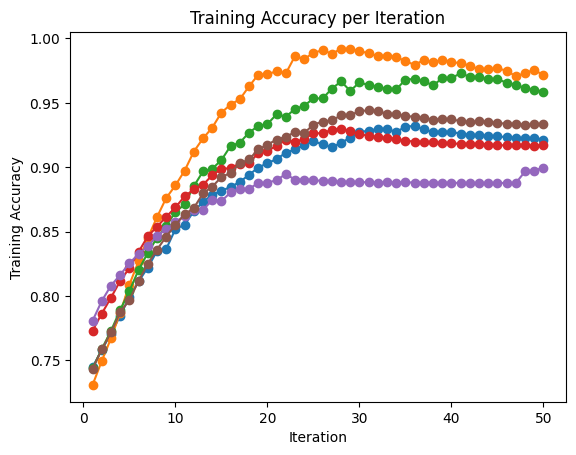

In [166]:
importlib.reload(train_eval_functions)
from train_eval_functions import *
from sklearn.neural_network import MLPClassifier

load_functions = [
    load_data_scenario_1,
    load_data_scenario_2,
    load_data_scenario_3,
    load_data_scenario_4,
    load_data_scenario_5,
    load_data_scenario_6
]

save_paths = [
    'mlp_imputed_1',
    'mlp_imputed_2',
    'mlp_imputed_3',
    'mlp_imputed_4',
    'mlp_imputed_5',
    'mlp_imputed_6'
]

all_was_dist = []
all_sp = []
all_eo = []
all_max_gap = []

for idx, load_func in enumerate(load_functions):
    X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_func(imputed=True)

    #model = joblib.load("./mlp_imputed/"+save_paths[idx]+"_weights.pkl")

    model = MLPClassifier(max_iter=1, warm_start=True, random_state=42)
    model = train_over_iterations(model, X_train, y_train, 50, save_as="./mlp_imputed/"+save_paths[idx]+"_training.png")
    #mode = train_to_convergence(model, X_train_filled, y_train)
    evaluate(model, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as="./mlp_imputed/"+save_paths[idx]+"_eval.txt")

    sp, eo, max_gap = get_fairness_metrics(model, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True)
    all_sp.append(sp)
    all_eo.append(eo)
    all_max_gap.append(max_gap)

    wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
    all_was_dist.append(wd)

    joblib.dump(model, "./mlp_imputed/"+save_paths[idx]+"_weights.pkl")


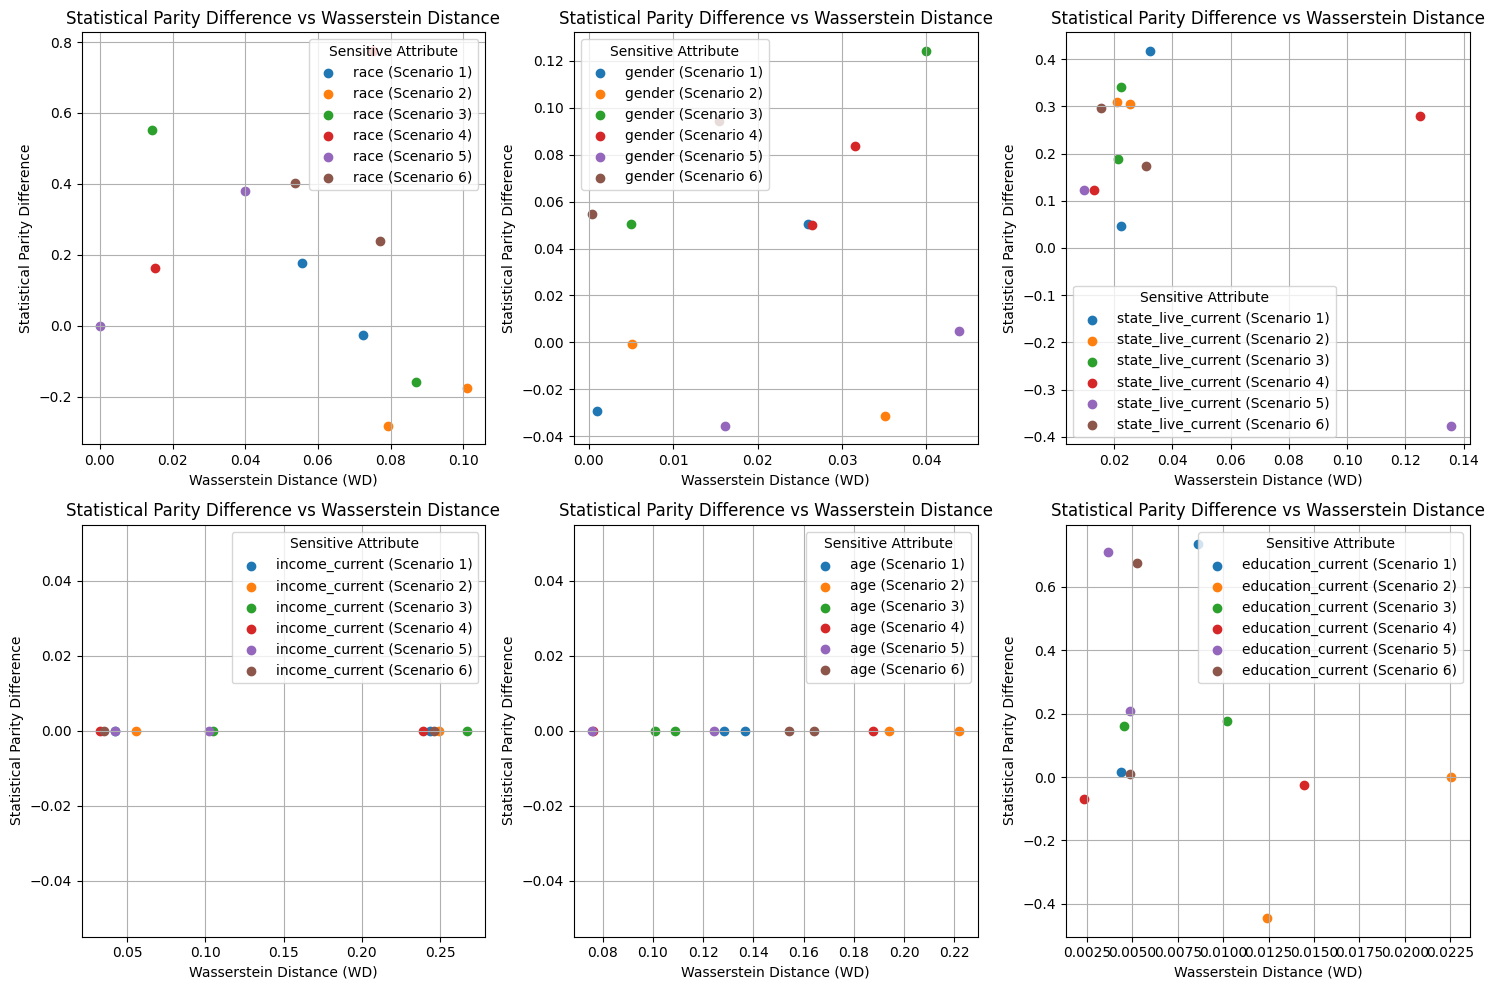

In [167]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_sp)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_sp[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Statistical Parity Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Statistical Parity Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

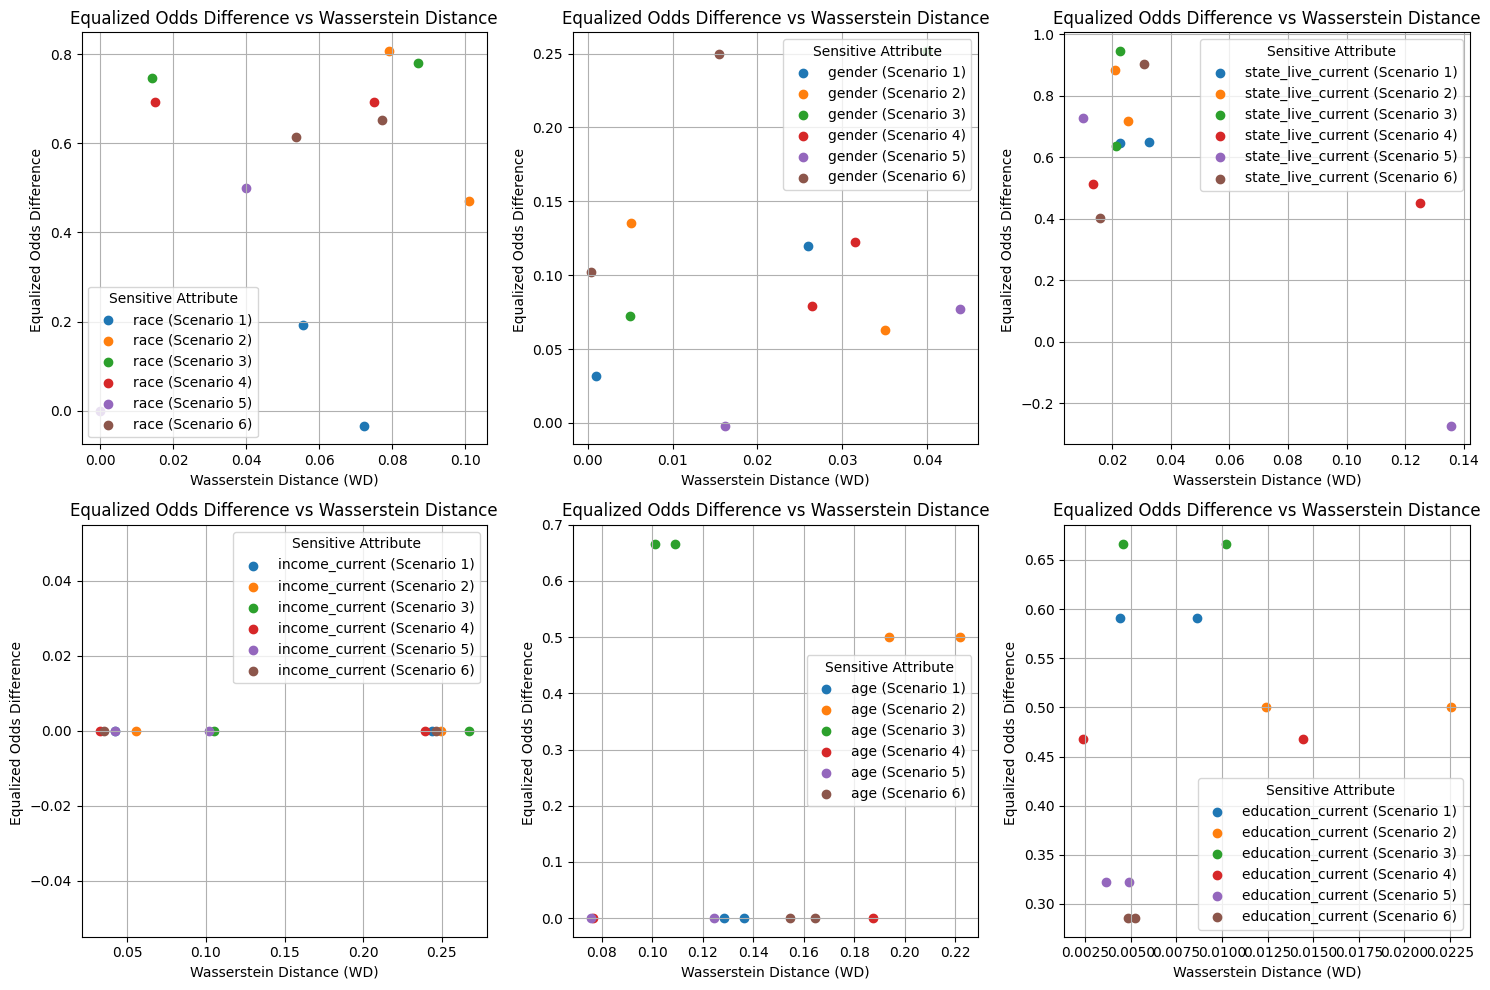

In [168]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_eo)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_eo[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Equalized Odds Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Equalized Odds Difference ")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

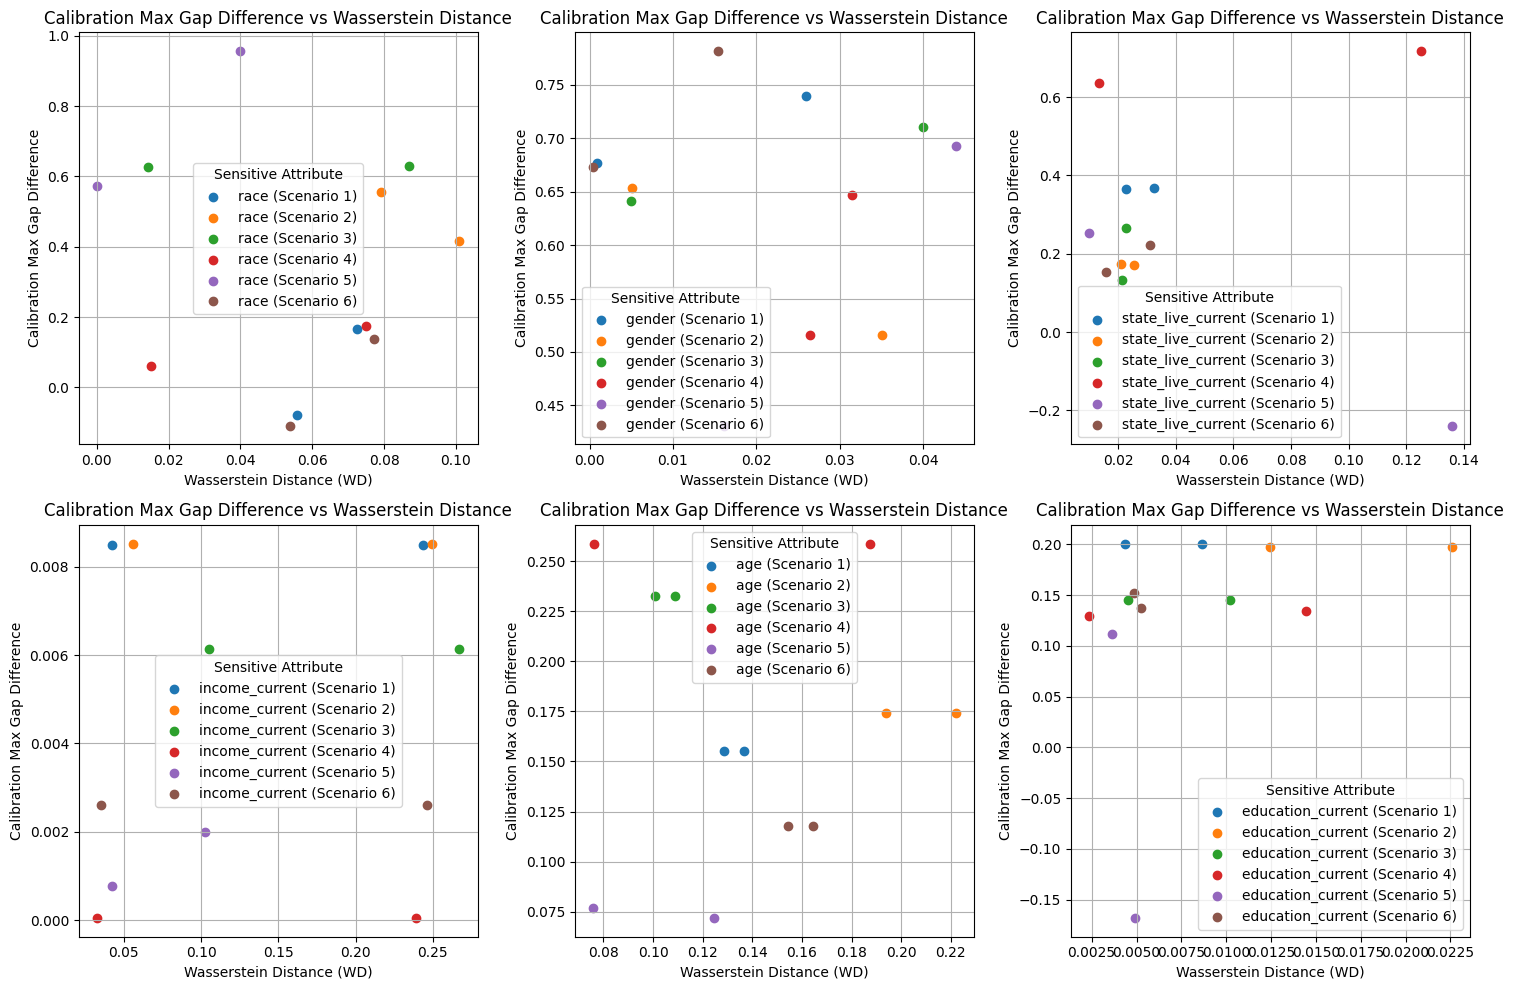

In [169]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_max_gap)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_max_gap[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Calibration Max Gap Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Calibration Max Gap Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [170]:
#save

import pickle

with open('./mlp_imputed/mlp_imputed_was_dist.pkl', 'wb') as file:
    pickle.dump(all_was_dist, file)

with open('./mlp_imputed/mlp_imputed_sp.pkl', 'wb') as file:
    pickle.dump(all_sp, file)

with open('./mlp_imputed/mlp_imputed_eo.pkl', 'wb') as file:
    pickle.dump(all_eo, file)

with open('./mlp_imputed/mlp_imputed_max_gap.pkl', 'wb') as file:
    pickle.dump(all_max_gap, file)

# Imputed Exponentiated Gradient

For comparison, here's imputed log reg to figure out how long to train and hyperparams

In [184]:
importlib.reload(train_eval_functions)
from train_eval_functions import *

X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_1(imputed=True)

logistic_reg = joblib.load("./log_reg_imputed/logistic_reg_imputed_1_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(logistic_reg, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=False)
wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=False)


/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:40: FutureWarning: Downcasting obje

race:

Statistical Parity Difference (Train): 0.323805202661827
Equalized Odds Difference (Train): 0.5743609604957398
Max Calibration Gap (Train): 0.26989880006653977

Statistical Parity Difference (ID Test): 0.38461538461538464
Equalized Odds Difference (ID Test): 0.8461538461538461
Max Calibration Gap (ID Test): 0.6293220713009213

Statistical Parity Difference (OOD Test): 0.2727272727272727
Equalized Odds Difference (OOD Test): 0.3333333333333333
Max Calibration Gap (OOD Test): 0.9303434300682328

gender:

Statistical Parity Difference (Train): 0.06004568431827756
Equalized Odds Difference (Train): 0.04381883352109574
Max Calibration Gap (Train): 0.10553557707035141

Statistical Parity Difference (ID Test): 0.050020669698222414
Equalized Odds Difference (ID Test): 0.045588235294117596
Max Calibration Gap (ID Test): 0.3495447019296849

Statistical Parity Difference (OOD Test): 0.06810262907823883
Equalized Odds Difference (OOD Test): 0.18787878787878787
Max Calibration Gap (OOD Test)

In [185]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_1(imputed=True)

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:40: FutureWarning: Downcasting obje

Final Accuracy: 0.7328966652794615
Time to execute: 11.585917949676514, it/s: 1.7262335264991595
Accuracy History: [0.7422331590279914, 0.7422331590279914, 0.7422331590279914, 0.7422331590279914, 0.7422331590279914, 0.7422331590279914, 0.7422331590279914, 0.7422331590279914, 0.7422331590279914, 0.7422331590279914, 0.7422331590279914, 0.7422331590279914, 0.7374744422530624, 0.7374744422530624, 0.7374744422530624, 0.73295094721986, 0.73295094721986, 0.73295094721986, 0.7328966652794615, 0.7328966652794615]


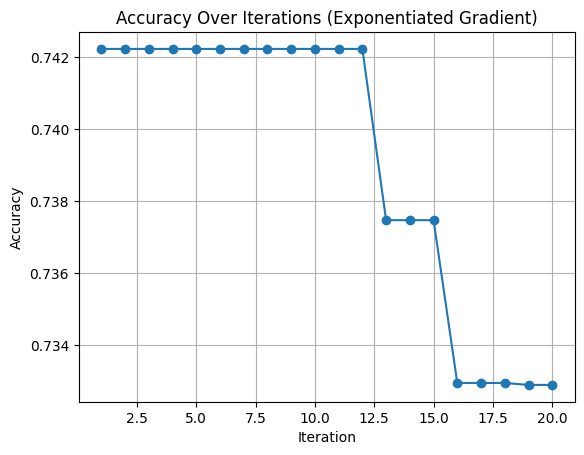

In [ ]:
EXP_GRAD_SENS_ATTR = "race"
clf = LogisticRegression(max_iter=20, warm_start=True, random_state=42)
objective = ErrorRate(costs={'fp': 0.5, 'fn': 0.5})
constraint = DemographicParity(difference_bound=0.05) # can be changed to other constraints instead 
# see fairlearn.reduction around here: https://fairlearn.org/main/api_reference/generated/fairlearn.reductions.DemographicParity.html\
ITERATIONS = 20 # note can't use the train_over_iterations because expotentiatedgradient doesnt allow for multiple fit() calls
mitigator = ExponentiatedGradient(clf, constraint, objective=objective, max_iter=ITERATIONS)
start = time.time()
accuracy_history = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    mitigator.fit(X_train, y_train, sensitive_features=X_train[EXP_GRAD_SENS_ATTR])

    predictors = mitigator.predictors_ 
    weights = mitigator.weights_ 

    for i in range(min(len(predictors), ITERATIONS)): 
        combined_proba = np.zeros((X_train.shape[0], 2)) 
        for j in range(i + 1): 
            combined_proba += weights[j] * predictors[j].predict_proba(X_train)
        y_train_pred = np.argmax(combined_proba, axis=1)
        acc = accuracy_score(y_train, y_train_pred)
        accuracy_history.append(acc)

elapsed = time.time() - start
final_accuracy = accuracy_history[-1]

plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Iterations (Exponentiated Gradient)")
plt.grid(True)
plt.show()

In [193]:
sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=False, expo_grad=True)

race:

Statistical Parity Difference (Train): 0.1179610354950627
Equalized Odds Difference (Train): 0.2770534615812228
Max Calibration Gap (Train): 0.5465875414750943

Statistical Parity Difference (ID Test): 0.46153846153846156
Equalized Odds Difference (ID Test): 0.7692307692307693
Max Calibration Gap (ID Test): 0.3575835796552652

Statistical Parity Difference (OOD Test): 0.4696969696969697
Equalized Odds Difference (OOD Test): 0.85
Max Calibration Gap (OOD Test): 0.9569930193662618

gender:

Statistical Parity Difference (Train): 0.07842697076475968
Equalized Odds Difference (Train): 0.06992498138765244
Max Calibration Gap (Train): 0.08349879250594726

Statistical Parity Difference (ID Test): 0.13704009921455146
Equalized Odds Difference (ID Test): 0.1185897435897436
Max Calibration Gap (ID Test): 0.5178344238055008

Statistical Parity Difference (OOD Test): 0.14254038644282546
Equalized Odds Difference (OOD Test): 0.34090909090909094
Max Calibration Gap (OOD Test): 0.9489270752136

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:40: FutureWarning: Downcasting obje

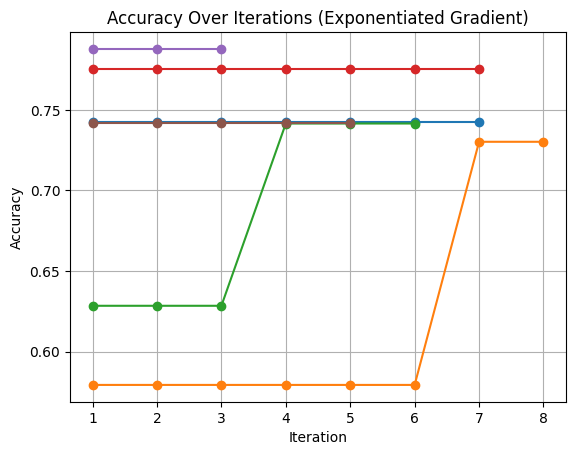

In [206]:
importlib.reload(train_eval_functions)
from train_eval_functions import *
from sklearn.neural_network import MLPClassifier

load_functions = [
    load_data_scenario_1,
    load_data_scenario_2,
    load_data_scenario_3,
    load_data_scenario_4,
    load_data_scenario_5,
    load_data_scenario_6
]

save_paths = [
    'exponentiated_grad_imputed_1',
    'exponentiated_grad_imputed_2',
    'exponentiated_grad_imputed_3',
    'exponentiated_grad_imputed_4',
    'exponentiated_grad_imputed_5',
    'exponentiated_grad_imputed_6'
]

all_was_dist = []
all_sp = []
all_eo = []
all_max_gap = []

for idx, load_func in enumerate(load_functions):
    X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_func(imputed=True)

    #model = joblib.load("./exponentiated_gradient_imputed/"+save_paths[idx]+"_weights.pkl")

    EXP_GRAD_SENS_ATTR = "gender"
    clf = LogisticRegression(max_iter=20, warm_start=True, random_state=42)
    objective = ErrorRate(costs={'fp': 0.5, 'fn': 0.5})
    constraint = DemographicParity(difference_bound=0.05) # can be changed to other constraints instead 
    # see fairlearn.reduction around here: https://fairlearn.org/main/api_reference/generated/fairlearn.reductions.DemographicParity.html\
    ITERATIONS = 20 # note can't use the train_over_iterations because expotentiatedgradient doesnt allow for multiple fit() calls
    mitigator = ExponentiatedGradient(clf, constraint, objective=objective, max_iter=ITERATIONS)
    start = time.time()
    accuracy_history = []
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        mitigator.fit(X_train, y_train, sensitive_features=X_train[EXP_GRAD_SENS_ATTR])

        predictors = mitigator.predictors_ 
        weights = mitigator.weights_ 

        for i in range(min(len(predictors), ITERATIONS)): 
            combined_proba = np.zeros((X_train.shape[0], 2)) 
            for j in range(i + 1): 
                combined_proba += weights[j] * predictors[j].predict_proba(X_train)
            y_train_pred = np.argmax(combined_proba, axis=1)
            acc = accuracy_score(y_train, y_train_pred)
            accuracy_history.append(acc)

    elapsed = time.time() - start
    final_accuracy = accuracy_history[-1]

    plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o')
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Iterations (Exponentiated Gradient)")
    plt.grid(True)
    plt.savefig(f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/{save_paths[idx]}_training.png")
    evaluate(model, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/{save_paths[idx]}_eval.txt")

    sp, eo, max_gap = get_fairness_metrics(model, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
    all_sp.append(sp)
    all_eo.append(eo)
    all_max_gap.append(max_gap)

    wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
    all_was_dist.append(wd)

    joblib.dump(model, f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/{save_paths[idx]}_weights.pkl")


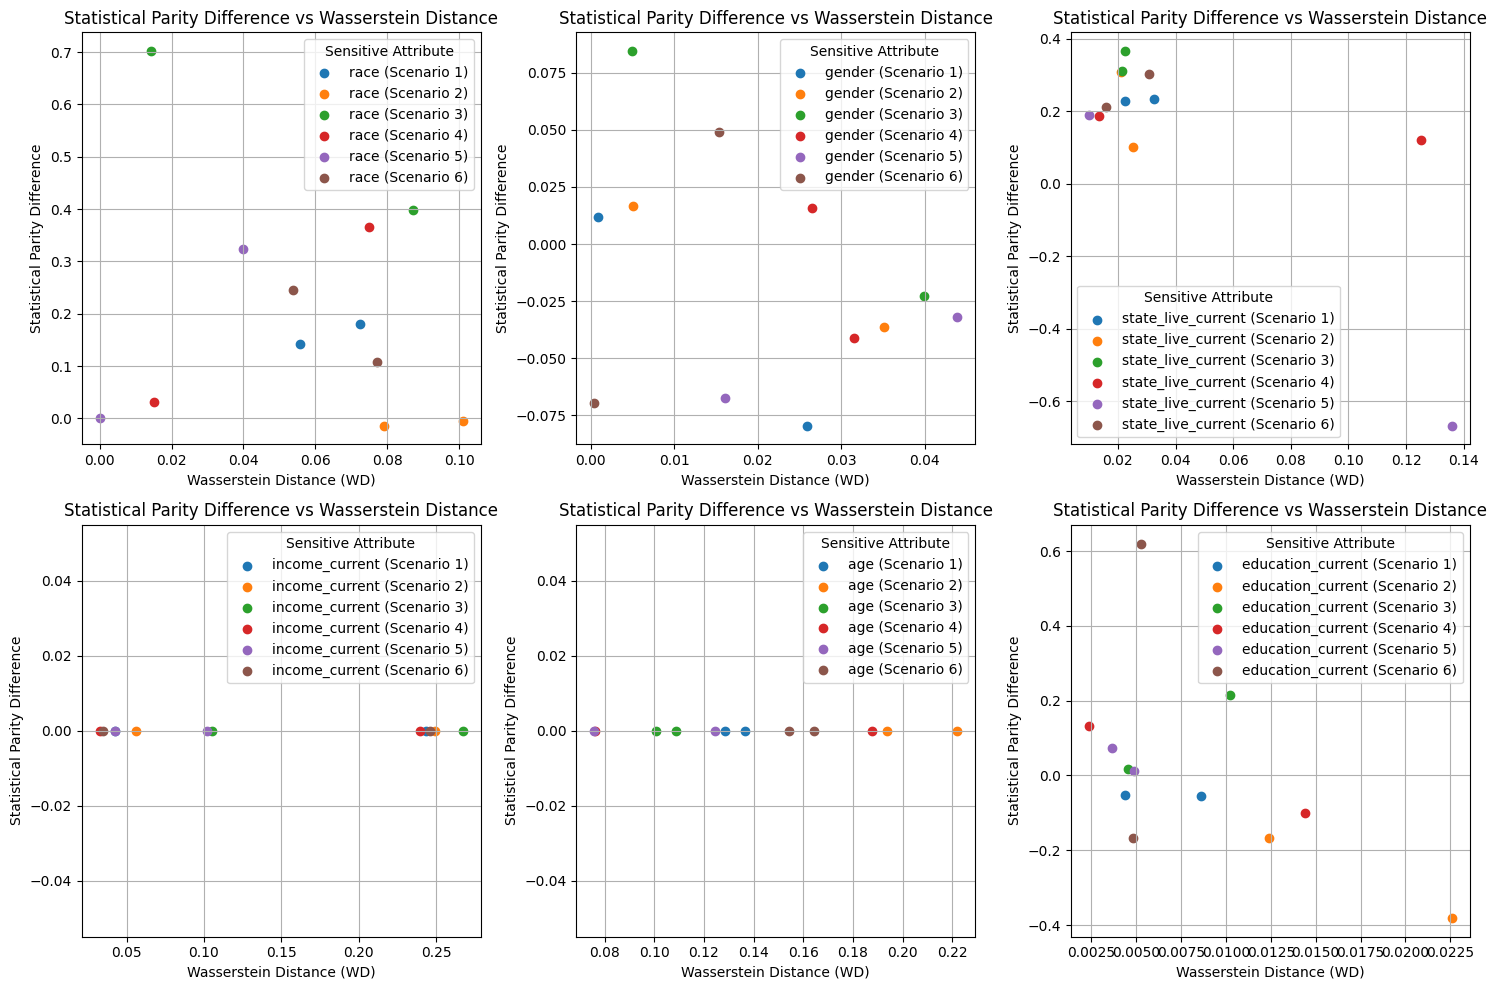

In [207]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_sp)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_sp[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Statistical Parity Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Statistical Parity Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

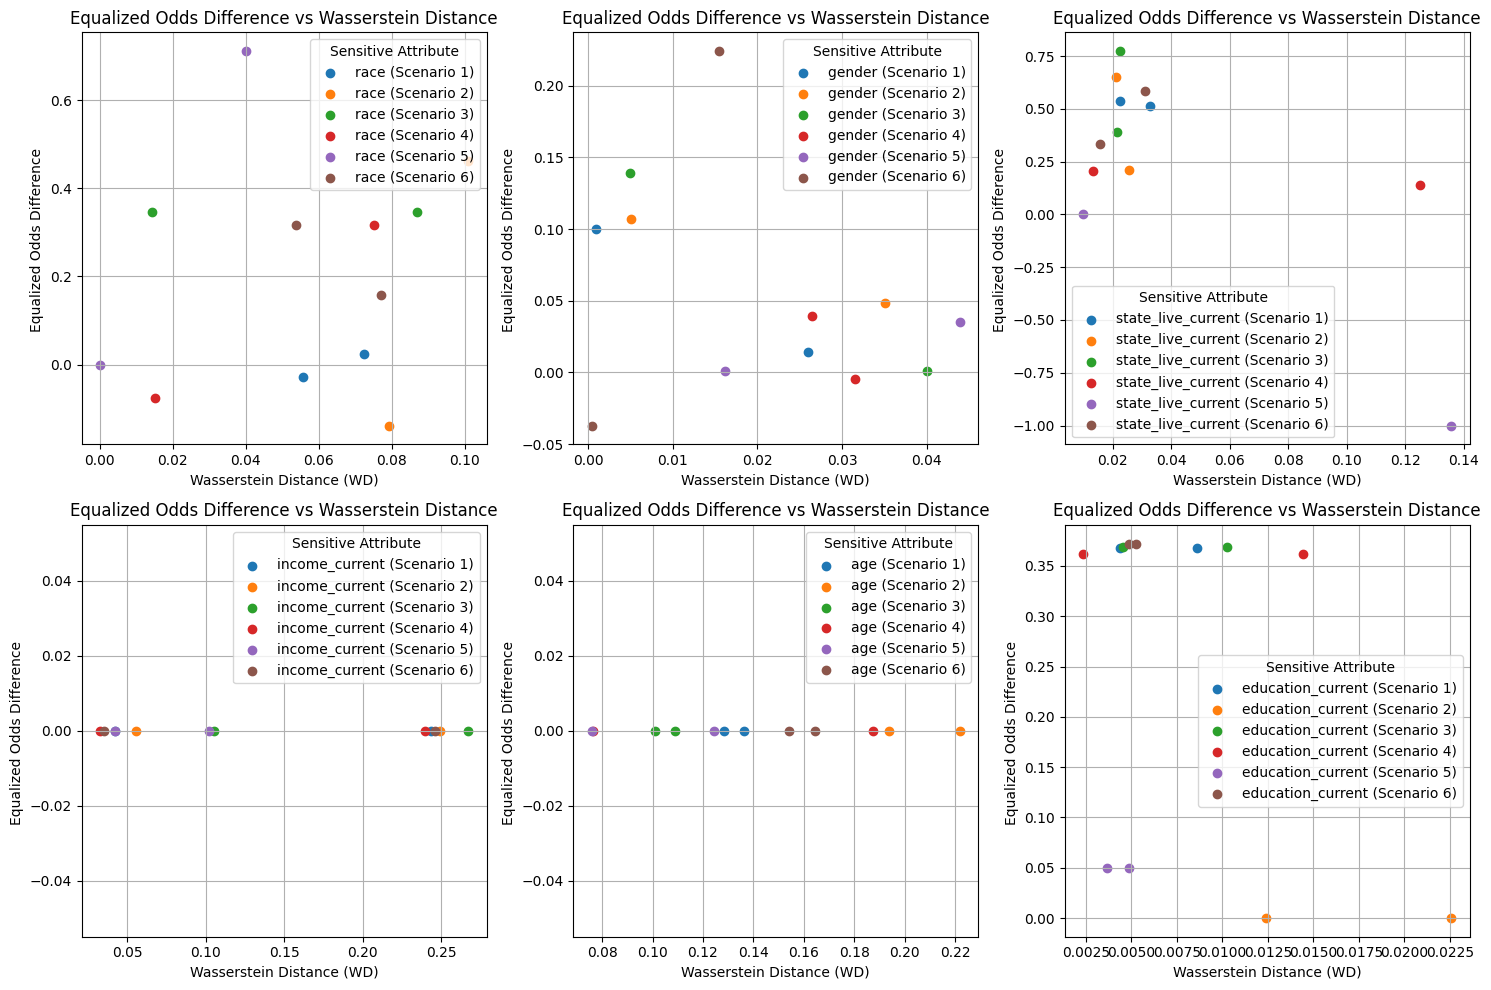

In [208]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_eo)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_eo[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Equalized Odds Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Equalized Odds Difference ")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

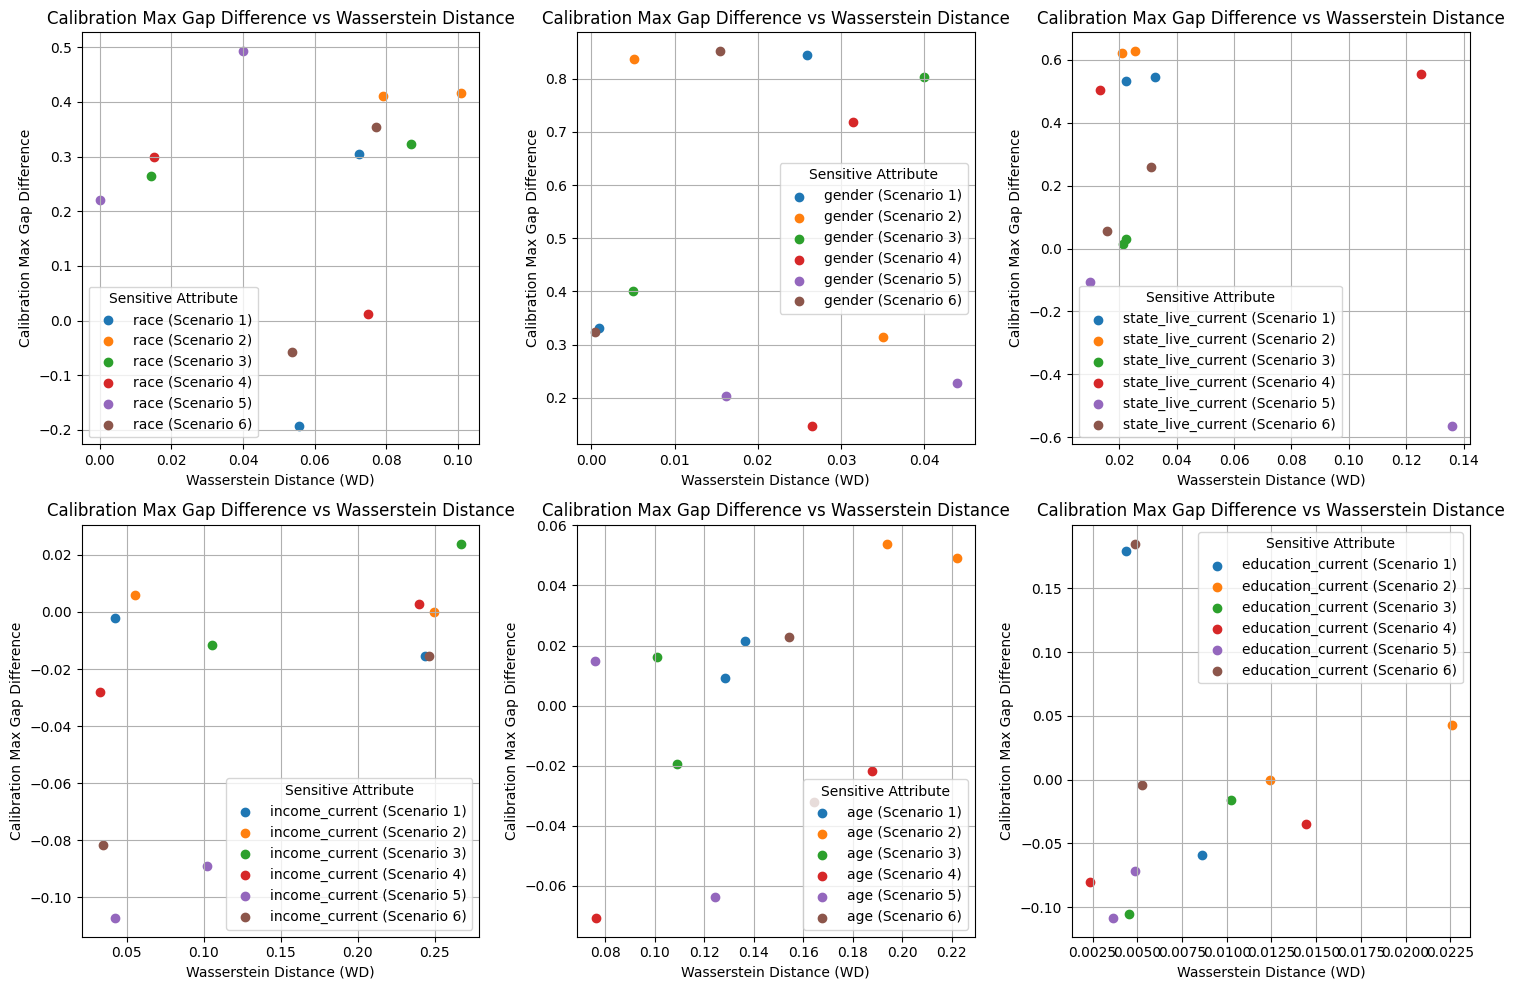

In [209]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_max_gap)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_max_gap[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Calibration Max Gap Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Calibration Max Gap Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [210]:
#save

import pickle

with open(f'./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_gradient_imputed_was_dist.pkl', 'wb') as file:
    pickle.dump(all_was_dist, file)

with open(f'./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_gradient_imputed_sp.pkl', 'wb') as file:
    pickle.dump(all_sp, file)

with open(f'./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_gradient_imputed_eo.pkl', 'wb') as file:
    pickle.dump(all_eo, file)

with open(f'./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_gradient_imputed_max_gap.pkl', 'wb') as file:
    pickle.dump(all_max_gap, file)

# Adversarial Classifier

Comparison to figure out hyperparameters

In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_1(imputed=True)

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_28178/2849292405.py:40: FutureWarning: Downcasting obje

In [214]:
EXP_GRAD_SENS_ATTR = "race"
ITERATIONS = 500 # note can't use the train_over_iterations because expotentiatedgradient doesnt allow for multiple fit() calls

mitigator = AdversarialFairnessClassifier(
    backend="torch",
    predictor_model=[100,"relu",2], # this is number of nodes and then activation function, see here: https://fairlearn.org/main/api_reference/generated/fairlearn.adversarial.AdversarialFairnessClassifier.html#:~:text=a%20BackendEngine%20class.-,predictor_model,-list%2C%20torch.nn
    adversary_model=[3, "leaky_relu"],
    batch_size=32,
    learning_rate=0.0001,
    progress_updates=0.25,
    # alpha=0.1,
    random_state=5,
    epochs=8
    #contraints = "demographic_parity" # we can chagne this to equalized_odds as per https://fairlearn.org/main/api_reference/generated/fairlearn.adversarial.AdversarialFairnessClassifier.html#:~:text=constraintsstr%2C%20default,demographic_parity%E2%80%99%20or%20%E2%80%98equalized_odds%E2%80%99.
)


start = time.time()
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    mitigator.fit(X_train, y_train, sensitive_features=X_train[EXP_GRAD_SENS_ATTR])
    y_train_pred = mitigator.predict(X_train)
    acc = accuracy_score(y_train, y_train_pred)
    print(f"Accuracy: {acc}")
    elapsed = time.time() - start
    print(f"Time to execute: {elapsed}, it/s: {ITERATIONS/elapsed}")

# train_over_iterations(mitigator_f, X_train_imp_drop_normed,y_train_dropped, 20,
#                       sensitive_a_data = X_train_imp_dropped[EXP_GRAD_SENS_ATTR])


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/zengsimon/miniconda3/envs/hrs/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/zengsimon/miniconda3/envs/hrs/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/zengsimon/miniconda3/envs/hrs/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  

RuntimeError: Numpy is not available

In [ ]:
importlib.reload(train_eval_functions)
from train_eval_functions import *
from sklearn.neural_network import MLPClassifier

load_functions = [
    load_data_scenario_1,
    load_data_scenario_2,
    load_data_scenario_3,
    load_data_scenario_4,
    load_data_scenario_5,
    load_data_scenario_6
]

save_paths = [
    'adversarial_classifier_1',
    'adversarial_classifier_2',
    'adversarial_classifier_3',
    'adversarial_classifier_4',
    'adversarial_classifier_5',
    'adversarial_classifier_6'
]

all_was_dist = []
all_sp = []
all_eo = []
all_max_gap = []

for idx, load_func in enumerate(load_functions):
    X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_func(imputed=True)

    #model = joblib.load("./adversarial_classifier/"+save_paths[idx]+"_weights.pkl")

    model = MLPClassifier(max_iter=1, warm_start=True, random_state=42)
    model = train_over_iterations(model, X_train, y_train, 50, save_as="./adversarial_classifier/"+save_paths[idx]+"_training.png")
    #mode = train_to_convergence(model, X_train_filled, y_train)
    evaluate(model, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as="./adversarial_classifier/"+save_paths[idx]+"_eval.txt")

    sp, eo, max_gap = get_fairness_metrics(model, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
    all_sp.append(sp)
    all_eo.append(eo)
    all_max_gap.append(max_gap)

    wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
    all_was_dist.append(wd)

    joblib.dump(model, "./adversarial_classifier/"+save_paths[idx]+"_weights.pkl")


In [ ]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_sp)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_sp[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Statistical Parity Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Statistical Parity Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_eo)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_eo[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Equalized Odds Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Equalized Odds Difference ")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the figure size as needed

# Populate each subplot with a unique plot
for i, ax in enumerate(axes.flat):  # Flatten the grid to loop over each subplot
    attribute = protected_attributes[i]
    for x in range(len(all_max_gap)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_max_gap[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    # Add titles and labels
    ax.set_title(f"Calibration Max Gap Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Calibration Max Gap Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#save

import pickle

with open('./adversarial_classifier/adversarial_classifier_was_dist.pkl', 'wb') as file:
    pickle.dump(all_was_dist, file)

with open('./adversarial_classifier/adversarial_classifier_sp.pkl', 'wb') as file:
    pickle.dump(all_sp, file)

with open('./adversarial_classifier/adversarial_classifier_eo.pkl', 'wb') as file:
    pickle.dump(all_eo, file)

with open('./adversarial_classifier/adversarial_classifier_max_gap.pkl', 'wb') as file:
    pickle.dump(all_max_gap, file)